# Create a dataset of faces dividing them in fake and real

### Libraries, constants and pre-trained MTCNN

Install FaceNet-PyTorch if it's not already installed (it includes the pre-trained MTCNN model):

In [1]:
!pip install facenet-pytorch Pillow pandas

Import the necessary libraries:

In [2]:
import numpy as np
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2
from random import randint
from PIL import Image

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


Import the pre-trained MTCNN:

[Guide on how to use MTCNN](https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch/notebook)

In [4]:
from facenet_pytorch import MTCNN

Constants:

In [5]:
from constants import ORIGINAL_VIDEOS_FOLDER, FAKE_VIDEOS_FOLDER, FACES_FOLDER, FACES_REAL, FACES_FAKE

Lists of fake and real videos:

In [6]:
ORIGINAL_VIDEOS = os.listdir(ORIGINAL_VIDEOS_FOLDER)
FAKE_VIDEOS = os.listdir(FAKE_VIDEOS_FOLDER)

### Plot some examples

post_process avoids image normalization to be able to plot the images:

In [7]:
# Load the MTCNN in evaluation mode
# -> Evaluation deactivates Dropout layers, which speeds up the inference
mtcnn = MTCNN(select_largest=False, post_process=False, device=device).eval()

In [12]:
def plot_example(num_samples=3):
    """Plot the first frame of fake video and the extracted face"""
    _, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(18, 10))
    
    for i in range(num_samples):
        video_idx = randint(0, len(FAKE_VIDEOS)-1)

        # Fake video
        fake_video = cv2.VideoCapture(
            os.path.join(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS[video_idx]
        ))
        # Get the first frame
        _, fake_frame = fake_video.read()
        # BGR -> RGB
        fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB)

        # Convert the image (numpy array) to a Pillow Image
        frame = Image.fromarray(fake_frame)
        face = mtcnn(frame)

        # After being processed by MTCNN, the face has the shape: (CHANNELS, HEIGHT, WIDTH)
        # we have to change the change so that it has the shape (HEIGHT, WIDTH, CHANNELS)
        face = face.permute(1, 2, 0)

        # Remember that the output of the model is a tensor where the pixel values are float values
        # To be able to plot the face, we have to convert it into a numpy array of integer values
        #
        # If the image is in the GPU, we also have to move it to the CPU
        face = face.cpu().detach().int().numpy()

        # Plot the frames
        ax[i, 0].imshow(fake_frame)
        ax[i, 1].imshow(face)
        ax[i, 0].set_title("Fake (full image)")
        ax[i, 1].set_title("Fake (face)")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

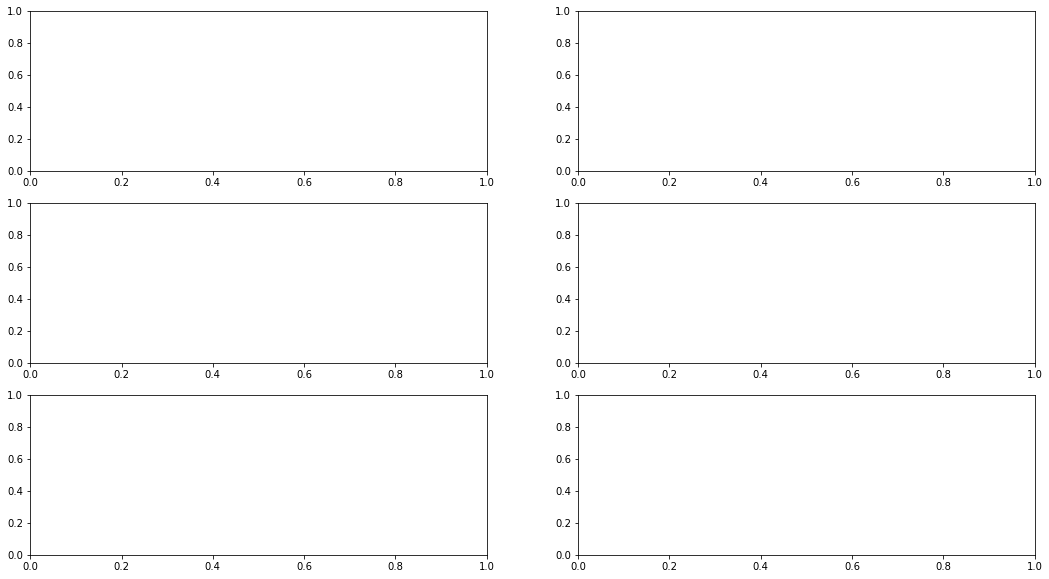

In [15]:
plot_example()

### Create the new dataset

Create a new folder where we'll store the face images:

In [16]:
!rm -rf ../data/faces/real

In [42]:
# !rm -rf ../data/faces

In [17]:
# os.mkdir(FACES_FOLDER)
os.mkdir(FACES_REAL)
# os.mkdir(FACES_FAKE)

In [18]:
!ls ../data/faces

faces.csv fake      real


Function to store the face images:

In [19]:
def get_face_name_from_video_name(video_name):
    """Get the face name from the video name"""
    img_name = video_name.split(".mp4")[0] # Remove the .mp4 extension
    return img_name + "_face.png" # Add the _face.png extension

In [23]:
def save_frame(fake_frame, video_name, faces_folder):
    fake_frame = cv2.cvtColor(fake_frame, cv2.COLOR_BGR2RGB) # BGR -> RGB

    frame = Image.fromarray(fake_frame)
    face = mtcnn(frame) # extract the face from the frame

    # if the face is not found on the image, we do not save it
    if face is None: return

    # (CHANNELS, HEIGHT, WIDTH) -> (HEIGHT, WIDTH, CHANNELS)
    face = face.permute(1, 2, 0)
    # face is a tensor where the pixel values are float32 values
    # -> move it to the CPU, convert it to int values and then to a numpy array 
    face = face.cpu().detach().numpy().astype(np.uint8)

    # Save the face
    img_name = get_face_name_from_video_name(video_name)
    Image.fromarray(face).save(os.path.join(faces_folder, img_name))

In [24]:
def save_face(videos_folder, videos_names, faces_folder, is_real=None):
    """Save the face of the video in the faces_folder"""
    for i in range(len(videos_names)):
        fake_video = cv2.VideoCapture(
            os.path.join(videos_folder, videos_names[i]
        ))

        # get a frame every 30 frames of fake_video only if is_real is True
        # otherwise, get a frame every frame of fake_video
        while fake_video.isOpened():
            if is_real is True:
                count = 0
                ret, real_frame = fake_video.read()
                if ret is True:
                    # the name has to be different for each frame
                    save_frame(real_frame, f"{videos_names[i]}_f{count}", faces_folder)

                    count += 30 # i.e. at 30 fps, this advances one second
                    real_frame.set(cv2.CAP_PROP_POS_FRAMES, count)
                else:
                    real_frame.release()
                    break
            else:
                ret, fake_frame = fake_video.read() # Get the first frame
                if ret is True:
                    save_frame(fake_frame, videos_names[i], faces_folder)
                else:
                    fake_frame.release()
                    break

In [26]:
# Store the faces of the real videos:
save_face(ORIGINAL_VIDEOS_FOLDER, ORIGINAL_VIDEOS, FACES_REAL, is_real=True)
# Store the faces of the fake videos:
# save_face(FAKE_VIDEOS_FOLDER, FAKE_VIDEOS, FACES_FAKE, is_real=False)

RuntimeError: Couldn't load custom C++ ops. This can happen if your PyTorch and torchvision versions are incompatible, or if you had errors while compiling torchvision from source. For further information on the compatible versions, check https://github.com/pytorch/vision#installation for the compatibility matrix. Please check your PyTorch version with torch.__version__ and your torchvision version with torchvision.__version__ and verify if they are compatible, and if not please reinstall torchvision so that it matches your PyTorch install.

### Save the images names with their label as a csv file

In [26]:
real_faces = os.listdir(FACES_REAL)
real_faces = np.array(list(zip(real_faces, ["real"]*len(real_faces))))
fake_faces = os.listdir(FACES_FAKE)
fake_faces = np.array(list(zip(fake_faces, ["fake"]*len(fake_faces))))

faces = np.concatenate((real_faces, fake_faces))

# shuffle the data
np.random.shuffle(faces)

In [27]:
df = pd.DataFrame(faces, columns=["name", "label"])

In [30]:
df.head(30)

,name,label
0,12_06__talking_against_wall__0VR4Y891_face.png,fake
1,23_19__walking_outside_cafe_disgusted__WHQ1229...,fake
2,03_18__walking_and_outside_surprised__22UBC0BS...,fake
3,23_24__kitchen_pan__YR5OVD4S_face.png,fake
4,06_25__outside_talking_still_laughing__MI9BDQ7...,fake
5,13_02__secret_conversation__PLNVLO74_face.png,fake
6,24_19__podium_speech_happy__OF8LF68K_face.png,fake
7,27_02__hugging_happy__UGO2181S_face.png,fake
8,20_14__podium_speech_happy__B014BKVO_face.png,fake
9,12_07__walking_and_outside_surprised__0VN0A2T3...,fake


In [29]:
df.to_csv(os.path.join(FACES_FOLDER, "faces.csv"))